# Modeling Optimization

## 1 Setup

In [66]:
import xgboost as xgb
import pickle
from wakepy import keep
import pandas as pd
import itertools
import seaborn as sns
from lazypredict.Supervised import LazyRegressor
import matplotlib.pyplot as plt
import sklearn.preprocessing as skp
import sklearn.metrics as skm
import sklearn.ensemble as ske
import sklearn.model_selection as sms
import sklearn.linear_model as skl

%matplotlib inline

## 2 Import der Daten

In [67]:
data_test = pd.read_csv("../data/prepared_test.csv", sep=";", index_col=0).sort_index()
data_test.head()

,dteday,yr,mnth,holiday,workingday,temp,atemp,hum,windspeed,leaflets,...,weekday_4,weekday_5,weekday_6,season_1,season_2,season_3,season_4,weathersit_1,weathersit_2,weathersit_3
instant,,,,,,,,,,,,,,,,,,,,,
7,07.01.2011,0,1,0,1,7.86,0.21,74.80,0.17,977,...,0,1,0,1,0,0,0,0,1,0
11,11.01.2011,0,1,0,1,6.76,0.19,102.95,0.12,1028,...,0,0,0,1,0,0,0,0,1,0
14,14.01.2011,0,1,0,1,6.43,0.19,80.67,0.13,481,...,0,1,0,1,0,0,0,1,0,0
16,16.01.2011,0,1,0,0,9.27,0.23,72.56,0.19,493,...,0,0,0,1,0,0,0,1,0,0
18,18.01.2011,0,1,0,1,8.67,0.23,129.25,0.15,989,...,0,0,0,1,0,0,0,0,1,0


In [68]:
data_train = pd.read_csv("../data/prepared_train.csv", sep=";", index_col=0
                         ).sort_index()
data_train.head()

,dteday,yr,mnth,holiday,workingday,temp,atemp,hum,windspeed,leaflets,...,weekday_4,weekday_5,weekday_6,season_1,season_2,season_3,season_4,weathersit_1,weathersit_2,weathersit_3
instant,,,,,,,,,,,,,,,,,,,,,
1,01.01.2011,0,1,0,0,13.77,0.36,120.87,0.16,755,...,0,0,1,1,0,0,0,0,1,0
2,02.01.2011,0,1,0,0,14.54,0.35,104.41,0.25,837,...,0,0,0,1,0,0,0,0,1,0
3,03.01.2011,0,1,0,1,7.85,0.19,65.59,0.25,829,...,0,0,0,1,0,0,0,1,0,0
4,04.01.2011,0,1,0,1,8.00,0.21,88.57,0.16,734,...,0,0,0,1,0,0,0,1,0,0
5,05.01.2011,0,1,0,1,9.08,0.23,65.54,0.19,745,...,0,0,0,1,0,0,0,1,0,0


## 3 Initial Model Selection ##

Zu Beginn legen wir die Variable multicolinear an, die eine Liste von Features enthält, die wir auf Basis der Berechnung der Variance Inflation Factors in Task 1, als multikollinear einstufen.

In [69]:
multicolinear = ["hum", "atemp"] #sollte das nicht atemp sein? [hum, atemp]

Im Anschluss führen wir eine Standardisierung der Features durch und teilen die Daten in Trainings- und Testsets auf. Durch die Standardisierung der Features wird sichergestellt, dass alle Features auf die gleiche Skala gebracht werden, was die Modelltrainingsprozesse verbessern kann.
Als data_features definieren wir eine Liste der Features aus den Trainingsdaten, wobei Spalten wie `dteday`, `casual`, `registered`, `cnt` und mögliche multikollineare Features entfernt werden.

In [70]:
scaler = skp.StandardScaler()
data_features = data_train.drop(
    columns=["dteday", "casual", "registered", "cnt", *multicolinear]).columns.to_list()

X_train = scaler.fit_transform(X=data_train[data_features], y=data_train["cnt"])

Y_train = data_train["cnt"].copy()

X_test = scaler.transform(data_test[data_features])

Y_test = data_test["cnt"].copy()

Für die Auswahl des Modelltyps verwenden wird die Bibliothek `lazypredict`. Sie erstellt 42 Regressionsmodelle verschiendener Typen mithilfe unseres Datensatzes.

In [71]:
reg = LazyRegressor(verbose=0, ignore_warnings=True, predictions=True)
models, pred = reg.fit(X_train, X_test, Y_train, Y_test)

100%|██████████| 42/42 [00:01<00:00, 23.71it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 650
[LightGBM] [Info] Number of data points in the train set: 592, number of used features: 20
[LightGBM] [Info] Start training from score 4455.685811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In diesem DataFrame sind die Metriken der jeweiligen Modelltypen zu sehen. Zu erkennen ist, dass der Typ `GradientBoostingRegressor` nach allen Metriken den höchsten Wert für Adjusted R-Squared erzielt. Weitere gut abschneidende Modelltypen sind der `XGBRegressor` und der `ExtraTreesRegressor`. Für das Parametertuning werden alle drei Typen näher betrachtet, da es sein könnte, dass eines der drei Modelle deutlich besser abschneidet, sobald die Hyperparameter angepasst werden.

In [72]:
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
GradientBoostingRegressor,0.85,0.88,688.72,0.15
ExtraTreesRegressor,0.81,0.84,773.69,0.28
LGBMRegressor,0.80,0.83,805.08,0.03
HistGradientBoostingRegressor,0.80,0.83,806.23,0.10
XGBRegressor,0.79,0.83,809.78,0.05
RandomForestRegressor,0.79,0.83,815.52,0.27
BaggingRegressor,0.78,0.82,829.64,0.05
RidgeCV,0.77,0.81,848.07,0.01
BayesianRidge,0.77,0.81,849.13,0.01


Auf dieser Grafik ist ein Vergleich zwischen tatsächlichen und vorhergesagten Daten des `GradientBoostingRegressor` zu sehen. Es ist zu erkennen, dass es einige Ausreißer nach unten gibt, die das Modell nicht abbilden konnte. Bei dem Wert am rechten Ende des Graphen konnte das Modell dies jedoch sehr gut.

In [73]:
def actualVsPredictChart(true_v, pred_v):
    data = {"Actual": true_v, "Predicted": pred_v}
    df = pd.DataFrame(data)

    # Create a lineplot with Seaborn
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 6))

    sns.lineplot(data=df, markers=False)

    plt.title("Actual vs. Predicted Values")
    plt.xlabel("Data Points")
    plt.ylabel("Values")

    plt.show()

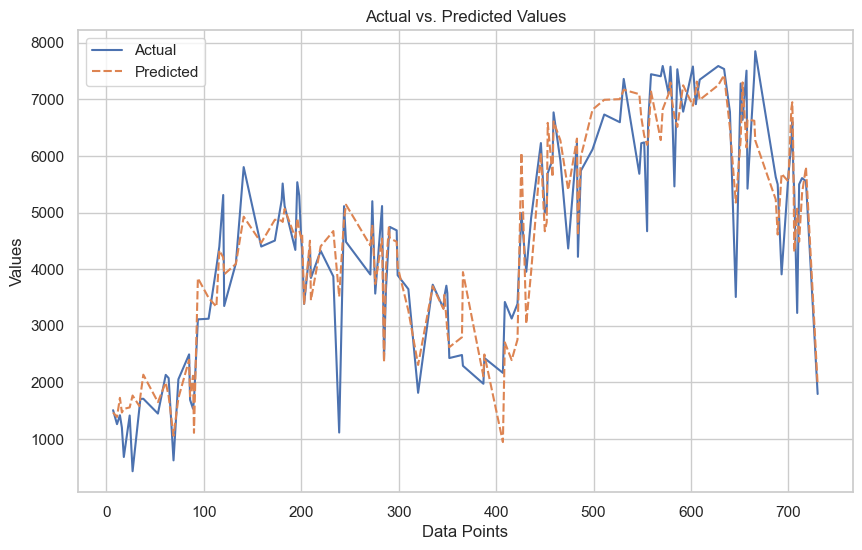

In [74]:
actualVsPredictChart(Y_test, pred["GradientBoostingRegressor"].to_numpy())

## 4 Hyperparamter Tuning

Im Folgenden probieren wir verschiedene Kombinationen von Hyperparametern für die drei ausgewählten Algorithmen aus, um jeweils die beste Leistung des Modells zu erzielen.

### 4.1 GradientBoostingRegressor

- **Loss**: Loss bezeichnet das Verlustmaß. Dieses soll minimiert werden. Wir verwenden die Methode "quantile" d.h. die Quantilregression. Hierdurch wird der quantile Fehler minimiert, was zu robusteren Regressionen führen kann. Desweiteren stehen die Methoden squared_error (Minimierung des mittleren quadratischer Fehlers zwischen vorhergesagten und tatsächlichen Werten), absolute_error (Minimierung des mittleren absoluten Fehlers zwischen vorhergesagten und tatsächlichen Werten) sowie huber (Kombination aus quadratischem und absolutem Fehler) zur Auswahl.
- **Alpha**: Der Alpha-Wert beeinflusst die Gewichtung der Residuals in der Quantilregression. Durch die Variation von alpha kann der Fokus auf unterschiedliche Quantile gelegt werden. Wir verwenden eine Liste von Werten von 0.2 bis 0.8 in Schritten von 0.2.
- **Criterion**: Hiermit ist das Kriterium gemeint, das zur Auswahl der besten Aufteilung in jedem Entscheidungsbaumknoten verwendet wird. In diesem Fall werden 'friedman_mse' und 'squared_error' verwendet. 'friedman_mse' ist eine verbesserte Version des mittleren quadratischen Fehlers (MSE) für Gradient Boosting.
- **Learning Rate**: Die Lernrate steuert, wie stark jeder Baum die vorherigen Bäume korrigiert. Eine niedrige Lernrate erfordert im Normalfall mehr Bäume, um den gleichen Effekt zu erzielen, kann jedoch im Gegenzug zu einer besseren Generalisierung führen. Hier werden Werte von 0.1 bis 0.5 in Schritten von 0.1 verwendet.
- **Max Depth**: Max Depth meint die maximale Tiefe eines einzelnen Entscheidungsbaums. Eine tiefere Baumstruktur kann zu Overfitting führen, während eine flachere Struktur zu Underfitting führen kann. Wir verwenden hier die Werte None, 5 und 10. None bedeutet, dass es keine festgelegte maximale Tiefe gibt.
- **Number of Estimators**: Hier wird die Anzahl der Bäume (Schätzer) im Ensemble festgelegt. Eine höhere Anzahl von Bäumen kann zu einer besseren Modellleistung führen, erfordert jedoch mehr Rechenressourcen. Wir legen die Werte 50, 100 und 200 zur Auswahl fest.

### 4.2 XGBRegressor

- **Number of Estimators**: Hier wird die Anzahl der Bäume (Schätzer) im Ensemble festgelegt. Eine höhere Anzahl von Bäumen kann zu einer besseren Modellleistung führen, erfordert jedoch mehr Rechenressourcen. Wir legen die Werte 50, 100 und 200 zur Auswahl fest.
- **Max Depth**: Max Depth meint die maximale Tiefe eines einzelnen Entscheidungsbaums. Eine tiefere Baumstruktur kann zu Overfitting führen, während eine flachere Struktur zu Underfitting führen kann. Wir verwenden hier die Werte None, 5 und 10. None bedeutet, dass es keine festgelegte maximale Tiefe gibt.
- **Max Leaves**: Max Leaves meint die maximale Anzahl von Blättern in einem Baum und begrenzt das Wachstum der Bäume.
- **Learning Rate**: Die Lernrate steuert, wie stark jeder Baum die vorherigen Bäume korrigiert. Eine niedrige Lernrate erfordert im Normalfall mehr Bäume, um den gleichen Effekt zu erzielen, kann jedoch im Gegenzug zu einer besseren Generalisierung führen. Hier werden Werte von 0.1 bis 0.5 in Schritten von 0.1 verwendet.
- **Booster**: Hier wird die Art des Boosters, der verwendet wird, festgelegt. "gbtree" steht für Entscheidungsbäume, "gblinear" für lineare Modelle und "dart" für Dropout-gestützte Entscheidungsbäume.
- **Grow Policy**: Die Grow Policy legt die Strategie für das Wachstum der Bäume fest. 0 steht für "depthwise", 1 für "lossguide". Bei "depthwise" wächst der Baum schichtweise, wohingegen "lossguide" eine strukturiertere Wachstumsrichtlinie basierend auf dem Verlust verwendet.
- **Gamma**: Dieser Paramter gibt an, wie stark ein Baumzweig, basierend auf dem Verlustrückgang, geschnitten wird. Ein höherer Gamma-Wert führt zu konservativerem Pruning.
- **Regularization Alpha**: Hiermit ist der L1 Regularisierungsterm auf den Gewichtungen der Blätter gemeint. Dieser hilft bei der Vermeidung von Overfitting durch Sparsamkeit.
- **Regularization Lambda**: Dieser Parameter meint den L2 Regularisierungsterm auf den Gewichtungen der Blätter und hilft bei der Vermeidung von Overfitting durch Schrumpfung der Gewichtungen.
- **Metric**: Metric meint die Bewertungsmetrik, die während des Trainings verwendet wird. Wir verwenden hier den Mean Absolute Error (skm.mean_absolute_error) als Bewertungsmetrik.

### 4.3 ExtraTressRegressor

- **Number of Estimators**: Hier wird die Anzahl der Bäume (Schätzer) im Ensemble festgelegt. Eine höhere Anzahl von Bäumen kann zu einer besseren Modellleistung führen, erfordert jedoch mehr Rechenressourcen. Wir legen die Werte 50, 100 und 200 zur Auswahl fest.
- **Criterion**: Criterion wählt das Kriterium aus, das zur Auswahl der besten Aufteilung in jedem Entscheidungsbaumknoten verwendet wird ,z.B. squared_error (mittlerer quadratischer Fehler), absolute_error (mittlerer absoluter Fehler), friedman_mse (verbesserte MSE für Gradient Boosting) oder poisson (Poisson-Regression für Zählvariablen).
- **Max Features**: Dieser Paramter definiert die maximale Anzahl der Merkmale, die für die Suche nach der besten Aufteilung in einem Baumknoten verwendet werden, z.B. sqrt (Quadratwurzel der Anzahl der Merkmale) oder log2 (Logarithmus zur Basis 2 der Anzahl der Merkmale):
- **Max Depth**: Max Depth meint die maximale Tiefe eines einzelnen Entscheidungsbaums. Eine tiefere Baumstruktur kann zu Overfitting führen, während eine flachere Struktur zu Underfitting führen kann. Wir verwenden hier die Werte None, 5 und 10. None bedeutet, dass es keine festgelegte maximale Tiefe gibt.

### 4.4 Auswahl der optimalen Hyperparamter

Im Folgenden werden alle Hyperparameter definiert. Die Listen enthalten die möglichen Werte eines jeden Parameters. Jedes Modell hat verschiedene Hyperarameter zur Auswahl, die bereits vorgestellt wurden.

In [75]:
gbRegressor = {
    "loss": ['quantile', 'squared_error', 'absolute_error', 'huber'],
    "alpha": [0.2*x for x in range(1, 5)],
    "criterion": ['friedman_mse', 'squared_error'],
    "learning_rate": [0.1*x for x in range(-2, 3)],
    "max_depth": [None, 5, 10],
    "n_estimators": [50, 100, 200]
}

xgbRegressor = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 5, 10],
    "max_leaves": [0, 5, 10, 20],
    "learning_rate": [0.2*x for x in range(1, 5)],
    "booster": ["gbtree", "gblinear", "dart"],
    "grow_policy": [0, 1],
    "gamma": [1e-3, 1e-1, 1],
    "reg_alpha": [1e-3, 1e-1, 1],
    "reg_lambda": [1e-3, 1e-1, 1],
    "metric": [skm.mean_absolute_error]
}

etRegressor = {
    "n_estimators": [50, 100, 200],
    "criterion": ["squared_error", "absolute_error", "friedman_mse", "poisson"],
    "max_features": ["sqrt", "log2"],
    "max_depth": [None, 3, 5, 10]
}

features = {
    ske.GradientBoostingRegressor: gbRegressor,
    xgb.XGBRegressor: xgbRegressor,
    ske.ExtraTreesRegressor: etRegressor
}

Mit Hilfe von Grid Search wird ein Hyperparameter-Tuning für jedes Modell durchgeführt, um jeweils die beste Kombination von Hyperparametern zu finden. Hierbei verwenden wir den negativen Mean Absolute Error als Bewertungsmetrik.

In [76]:
model_select_results = pd.DataFrame(columns=["model", "params", "mae"])

with keep.presenting():
    for model_type in features:
        gs_model = sms.GridSearchCV(estimator=model_type(random_state=1),
                                    param_grid=features[model_type],
                                    n_jobs=-1,
                                    scoring='neg_mean_absolute_error', )

        gs_model.fit(X_train, Y_train)
        print(f"Model type {str(model_type)}\nreached MAE of {gs_model.best_score_*-1}\n Params: {gs_model.best_params_}")
        model_select_results.loc[len(model_select_results)] = [type(gs_model.best_estimator_), gs_model.best_params_, gs_model.best_score_*-1]

model_select_results.sort_values("mae", ignore_index=True, inplace=True)

Model type <class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
reached MAE of 710.4672242542714
 Params: {'alpha': 0.2, 'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 5, 'n_estimators': 100}
Model type <class 'xgboost.sklearn.XGBRegressor'>
reached MAE of 670.9528314369592
 Params: {'booster': 'gblinear', 'gamma': 0.001, 'grow_policy': 0, 'learning_rate': 0.2, 'max_depth': None, 'max_leaves': 0, 'metric': <function mean_absolute_error at 0x0000023C6995BEC0>, 'n_estimators': 50, 'reg_alpha': 1, 'reg_lambda': 0.001}
Model type <class 'sklearn.ensemble._forest.ExtraTreesRegressor'>
reached MAE of 981.3022655604615
 Params: {'criterion': 'poisson', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200}


In [77]:
model_select_results

,model,params,mae
0,<class 'xgboost.sklearn.XGBRegressor'>,"{'booster': 'gblinear', 'gamma': 0.001, 'grow_...",670.95
1,<class 'sklearn.ensemble._gb.GradientBoostingR...,"{'alpha': 0.2, 'criterion': 'friedman_mse', 'l...",710.47
2,<class 'sklearn.ensemble._forest.ExtraTreesReg...,"{'criterion': 'poisson', 'max_depth': None, 'm...",981.30


Das Modell mit dem besten Ergebnis ist der DecisionTreeRegressor. Der MAE beträgt 713,8 für folgende Hyperparamter:

In [78]:
fin_model = model_select_results.loc[0, "model"]
fin_model

xgboost.sklearn.XGBRegressor

## Feature Selection ##

In [79]:
# Falls bereits ausgeführt, kann die Datei geladen werden
feature_results = pickle.load(open("feature_results.pkl", "rb"))

Diese Funktion gibt alle möglichen, einzigartigen Kombinationen der unabhängigen Variablen aus. Die Liste enthält die höchste Anzahl an Features zu Beginn und wird danach immer kürzer (Backward Eliminiation).

In [80]:
def get_feature_combinations(features, length):
    all_combinations = []
    for r in range(1, length + 1):
        combinations = itertools.combinations(features, r)
        all_combinations.extend(combinations)

    # Backwards Elimination
    return all_combinations[::-1]

Diese Funktion nimmt eine Liste von Indexes auf und gibt die Liste der numerischen Indexes zurück. Dies wird benötigt, da die `numpy`-Arrays nach der Skalierung numerische Indexes verwenden. Um auf bestimmte Features zuzugreifen, wird der numerische Index gebraucht.

In [81]:
def get_col_idx(cols, df):
    idx_lst = []
    for col in cols:
        idx_lst.append(df.columns.get_loc(col))

    return idx_lst

In [82]:
scaler = skp.StandardScaler()

X_train = data_train[data_features]
X_test = data_test[data_features]
Y_train = data_train["cnt"]
Y_test = data_test["cnt"]

X_train_sc = scaler.fit_transform(X_train, Y_train)
X_test_sc = scaler.transform(X_test)

Funktion zur Evaluation einer Feature-Kombination mittels MAE.

In [83]:
def eval_model_params(features):

    Xtr = X_train_sc[:, get_col_idx(features, X_train)]
    Xts = X_test_sc[:, get_col_idx(features, X_test)]

    reg = skl.Ridge(random_state=1)
    reg.fit(Xtr, Y_train)

    y_pred = reg.predict(Xts)
    mae = skm.mean_absolute_error(Y_test, y_pred)
    coefs = reg.coef_
    reg

    return dict(features=features,
                coefs=coefs,
                mae=mae)

Vorgehensweise:
- Es wird über alle möglichen Feature-Kombinationen iteriert und ein `Ridge`-Regressionsmodell erstellt. `Ridge` wird verwendet, da die `LinearRegression` Probleme mit overfitting verursacht.
- Die verwendeten Features, die Koeffizienten, sowie der MAE werden in einem DataFrame gespeichert.

In [84]:
num_of_features = len(data_features)
feature_list = get_feature_combinations(data_features, num_of_features)
c = 0
print("Feature combinations", len(feature_list))

Feature combinations 4194303


In [85]:
###########################
# Takes 45-60 minutes to run #
###########################

feature_results = [{"mae": 0}] # Fehlermeldung vermeiden
num_of_features = len(data_features)
feature_list = get_feature_combinations(data_features, num_of_features)
c = 0
print("Feature combinations", len(feature_list))
with keep.presenting():
    for feature_comb in feature_list:
        feature_results.append(eval_model_params(feature_comb))

        c+=1

        if c % 500 == 0:
            print(f"Evaluating {len(feature_comb)}/{len(data_features)} feature combinations (No. {c}) - MAE: {feature_results[-1]['mae']}", end="\r")

feature_results.remove({"mae": 0})

Feature combinations 4194303


In [86]:
feature_results = pd.DataFrame(feature_results).sort_values("mae").dropna()

Ausführungsergebnisse speichern

In [96]:
#file = open("feature_results.pkl", "wb")
#pickle.dump(feature_results.loc[:1000, :], file)

Eigenschaften der besten Modelle, sortiert nach dem MAE. Jede Zeile in dem DataFrame ist das Ergebnis eines Modells mit einer einzigartigen Feature-Kombination.

In [88]:
feature_results

,features,coefs,mae
1634286,"(yr, mnth, workingday, temp, leaflets, weekday...","[1008.063958902745, -46.84940642514341, 150.67...",621.56
2354941,"(yr, mnth, workingday, temp, weekday_4, weekda...","[1006.9834849208186, -47.656728579126394, 150....",621.89
510943,"(yr, mnth, workingday, temp, leaflets, price r...","[1007.7826051456365, -43.28534292333505, 166.6...",622.46
1630854,"(yr, mnth, workingday, temp, price reduction, ...","[1007.6107413013372, -45.029157099838216, 149....",622.74
983702,"(yr, mnth, workingday, temp, price reduction, ...","[1007.1164626704752, -43.760324747604436, 166....",622.76
...,...,...,...
4161549,"(price reduction, weekday_1, weekday_2, weekda...","[0.7610323623816043, -103.57605775791446, -32....",1655.49
4185881,"(weekday_1, weekday_2, weekday_6, season_2)","[-103.583173874345, -32.954152288481154, -35.8...",1655.60
4160129,"(weekday_1, weekday_2, weekday_3, weekday_6, s...","[-103.58092448335304, -32.951922695865, 0.0089...",1655.60
4185905,"(weekday_1, weekday_2, weekday_3, season_2)","[-94.62093428559659, -24.058649221071892, 9.04...",1655.65


Features des besten Modells, nach MAE gewertet

In [89]:
feature_results.iat[0, 0]

('yr',
 'mnth',
 'workingday',
 'temp',
 'leaflets',
 'weekday_4',
 'weekday_5',
 'weekday_6',
 'season_1',
 'season_4',
 'weathersit_1',
 'weathersit_2')

Um die Koeffizienten den jeweiligen Features zuordnen zu können, erstellen wir dafür ein separates DataFrame. Die Koeffizienten sind deshalb wichtig, da sie aussagen, wie wichtig ein Feature für eine genaue Vorhersage ist. Da die Daten bereits skaliert sind, sind alle Werte im Bereich [-1;1] und es gibt keine Gewichtungsunterschiede zwischen den Features

In [90]:
reg_dicts = []

for idx, row in feature_results.iterrows():
    reg_dicts.append({key: value for key, value in zip(row["features"], row["coefs"])})
coef_df = pd.DataFrame(data=reg_dicts)

Durchschnittliche Koeffizienten der jeweiligen Features im `Ridge`-Regressionsmodell

In [91]:
coef_df.describe().round(2).T.sort_index()

,count,mean,std,min,25%,50%,75%,max
holiday,2097152.00,-109.90,28.27,-202.91,-127.86,-111.64,-93.91,9.19
leaflets,2097152.00,-29.44,50.58,-132.26,-76.40,-31.34,12.36,84.03
mnth,2097152.00,156.02,260.56,-293.21,-31.14,47.45,330.53,869.02
price reduction,2097152.00,49.76,11.43,-7.73,43.03,50.78,57.73,79.46
season_1,2097152.00,-707.27,318.91,-1295.11,-998.80,-691.67,-429.20,-61.34
season_2,2097152.00,211.58,304.80,-313.41,13.21,173.20,379.14,999.41
season_3,2097152.00,197.32,419.83,-447.19,-170.41,221.98,480.38,1241.10
season_4,2097152.00,208.25,315.90,-393.49,14.83,271.49,412.56,899.66
temp,2097152.00,1078.01,154.48,727.44,975.39,1083.68,1197.07,1441.20
weathersit_1,2097152.00,585.07,440.47,196.92,300.23,382.67,642.36,1664.70


In [98]:
pickle.dump(coef_df.describe().round(2).T.sort_index(), open("coefficients.pkl", "wb"))

Erkenntnisse:
- Je höher die gefühlte Temperatur, desto mehr Kunden pro Tag
- An Feiertagen gibt es durchschnittlich 120 Kunden weniger
- Werbeblätter senken die tägliche Kundenzahl gering (<40)
- Je später im Jahr, desto mehr Kunden gibt es täglich (110/Monat) (Kundenzuwachs?)
- Eine Preisreduktion hat nur wenig Einfluss (+50)
- Die Jahreszeit hat einen bemerkenswerten Einfluss (~640/Jahresquartal)
- Bei gutem Wetter gibt es täglich 600 Kunden mehr
- Bei mäßigem Wetter bleibt die Kundenzahl beinahe neutral (+45)
- Bei schlechtem Wetter sind die Anzahl der Kunden (-400)
- Von Montag bis Mittwoch gibt es weniger Kunden, als gegen Ende der Woche
- Die Windgeschwindigkeit beeinflusst die Kundenanzahl negativ
- An Werktagen sind im Schnitt 140 Kunden mehr unterwegs
- Im Folgejahr gibt es etwa 1000 mehr Kunden (Kundenzuwachs)

## Final Model ##

In [123]:
def build_model(mtype, features, params):
    X_train = scaler.fit_transform(data_train.loc[:, features])
    X_test = scaler.transform(data_test.loc[:, features])
    Y_train = data_train["cnt"]
    Y_test = data_test["cnt"]

    fin_model = mtype(random_state=1, **params)

    fin_model.fit(X_train, Y_train)

    y_pred = fin_model.predict(X_test)

    mae = skm.mean_absolute_error(Y_test, y_pred)
    r2 = skm.r2_score(Y_test, y_pred)
    return [mtype, mae, r2, fin_model]

In [124]:
fin_features = feature_results.iat[0, 0]

In [127]:
fin_models = pd.DataFrame(columns=["modeltype", "mae", "r2", "model", "params"])
for idx, row in model_select_results.iterrows():
    fin_models.loc[len(fin_models)] = [*build_model(row["model"], fin_features, row["params"]), row["params"]]

In [128]:
fin_models

,modeltype,mae,r2,model,params
0,<class 'xgboost.sklearn.XGBRegressor'>,624.81,0.81,"XGBRegressor(base_score=None, booster='gblinea...","{'booster': 'gblinear', 'gamma': 0.001, 'grow_..."
1,<class 'sklearn.ensemble._gb.GradientBoostingR...,530.99,0.85,([DecisionTreeRegressor(criterion='friedman_ms...,"{'alpha': 0.2, 'criterion': 'friedman_mse', 'l..."
2,<class 'sklearn.ensemble._forest.ExtraTreesReg...,544.13,0.84,"(ExtraTreeRegressor(criterion='poisson', max_f...","{'criterion': 'poisson', 'max_depth': None, 'm..."


**Modelltyp**
- `sklearn.ensemble.GradientBoostingRegressor`

**Hyperparameter**
- Alpha: `0.6`
- Messkriterium: `friedman_mse`
- Lernrate: `0.1`
- Loss: `quantile`
- Maximale Baumtiefe: `5`
- Anzahl Regressoren: `200`
- (CPU-Kerne zu verwenden: `-1` (alle))

**Unabhängige Variablen / Features**
- `season`
- `yr`
- `mnth`
- `workingday`
- `atemp`
- `price reduction`
- `weekday_1`
- `weekday_5`
- `weekday_6`
- `weathersit_3`

## Cross Validation